# Multiclass SVM Classifier

## Data Preprocessing

In [86]:
import pandas as pd
import numpy as np
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler
from skimage.feature import hog

### Load data

In [87]:
name_path = './archive/lfw_allnames.csv'
images_path = './archive/lfw-deepfunneled/lfw-deepfunneled'

Only use classes with at least 100 images to simplify the problem.

In [88]:
df_names = pd.read_csv(name_path)
min_faces_per_person = 100
df_names = df_names.loc[df_names["images"] >= min_faces_per_person, :]
names = list(df_names["name"])

In [89]:
X = []
Y = []
# load images
for name in names:
    dir_path = os.path.join(images_path, name)
    list_images_name = os.listdir(dir_path)
    for image_name in list_images_name:
        image_path = os.path.join(dir_path, image_name)
        img_rgb = plt.imread(image_path)
        X.append(img_rgb)
        Y.append(name)
    print(f"Class: {name}, number of samples: {len(list_images_name)}.")
X = np.asarray(X)
Y = np.asarray(Y)

Class: Colin_Powell, number of samples: 236.
Class: Donald_Rumsfeld, number of samples: 121.
Class: George_W_Bush, number of samples: 530.
Class: Gerhard_Schroeder, number of samples: 109.
Class: Tony_Blair, number of samples: 144.


In [90]:
def create_features(img, show_hog=False):
    # flatten image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = np.array(0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2])
    # get HOG features from greyscale image
    hog_features, hog_image = hog(grey_image, visualize=True, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    if show_hog:
        plt.imshow(hog_image, cmap="gray")
    # combine color and hog features into a single array
    flat_features = np.hstack((color_features, hog_features))
    return flat_features

In [91]:
feature_matrix = []
for x in X:
    feature_matrix.append(create_features(x))

### PCA
Use PCA to reduce the data dimension.

In [92]:
# get shape of feature matrix
feature_matrix = np.asarray(feature_matrix)
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
pca.fit(bees_stand)
X_pca = pca.transform(bees_stand)
print('PCA matrix shape is: ', X_pca.shape)

Feature matrix shape is:  (1140, 201189)
PCA matrix shape is:  (1140, 500)


In [93]:
# label_encoder object knows  
# how to understand word labels. 
label_encoder = LabelEncoder() 
  
# Encode labels in column 'species'. 
Y = label_encoder.fit_transform(Y) 

In [94]:
# split dataset
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, Y, random_state=42)

## One-Against-All Multiclass SVM Classifier
One-against-all SVM is based on binary SVM [1]. The concept is that, for each class, a binary SVM is constructed by treating it as the positive class and all samples of the remaining N-1 classes as the negative class.

The mathematical formulations for the SVM hinge loss function and parameter updates are as follows.
**Loss funtion:**
$$L(\mathbf{w},b)=\frac1N\sum_{i=1}^N\max(0,1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b))$$
In this loss function, if a sample point is correctly classified, the loss is 0, otherwise the loss is $1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b)$

**Parameters update:**
The mathematical formula for parameter updating, using gradient descent, is an update of the gradient of the loss function with respect to weight and bias.
For weight $\mathbf{w}$:
$$\mathbf{w}\leftarrow\mathbf{w}-\alpha\left(\lambda\mathbf{w}-\frac1N\sum_{i=1}^N1(1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b)>0)\cdot y_i\cdot\mathbf{x}_i\right)$$
For bias $\mathbf{b}$:
$$b\leftarrow b-\alpha\frac1N\sum_{i=1}^N1(1-y_i(\mathbf{w}\cdot\mathbf{x}_i+b)>0)\cdot y_i$$

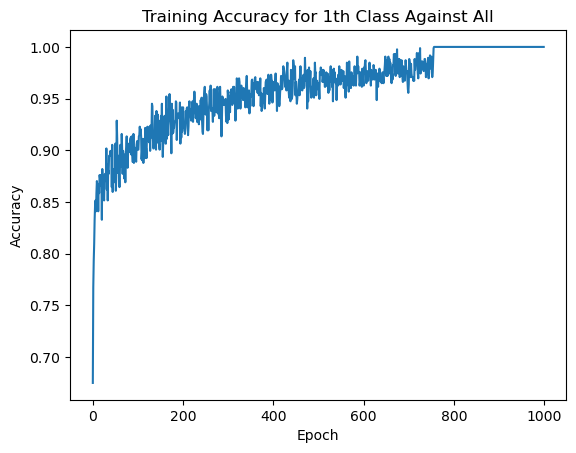

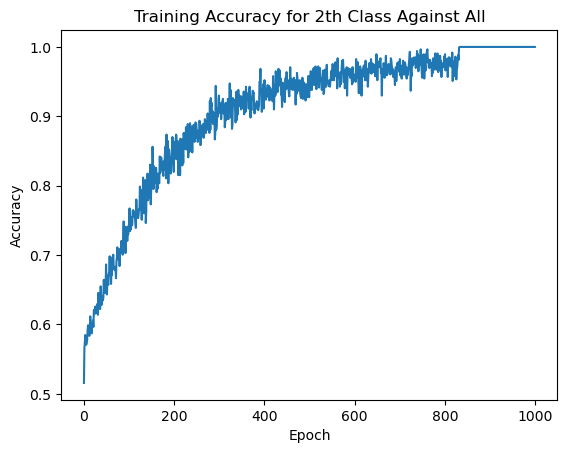

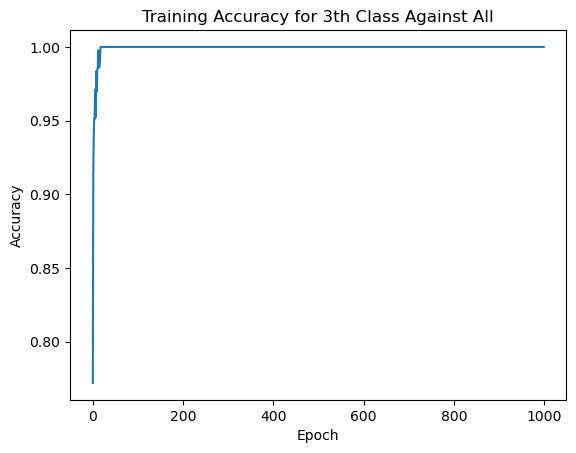

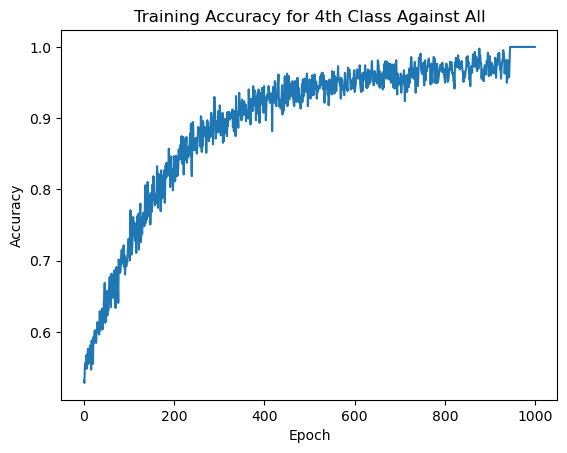

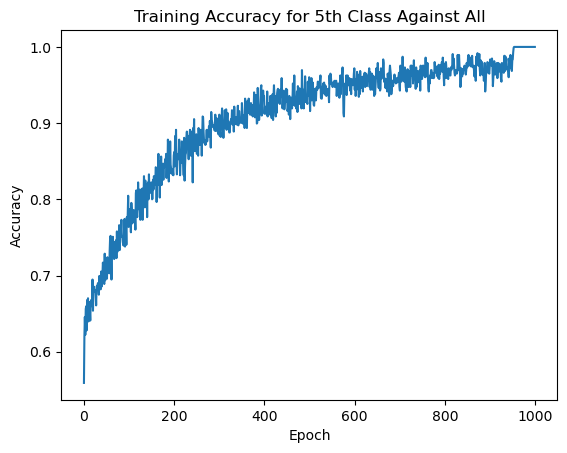

Accuracy on test set: 0.9087719298245615


In [111]:
import matplotlib.pyplot as plt

class SVM:
    def __init__(self, learning_rate=0.001, lambda_=2, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.lambda_ = lambda_
        self.weights = None
        self.bias = None
        self.cnt = 0
        self.accuracy = []

    def train(self, X, y):
        num_samples, num_features = X.shape
        unique_classes = np.unique(y)
        num_classes = len(unique_classes)

        # Initialize weights and bias
        self.weights = np.zeros((num_classes, num_features))
        self.bias = np.zeros(num_classes)

        # One-vs-All training
        for c in range(num_classes):
            binary_labels = np.where(y == unique_classes[c], 1, -1)
            self.accuracy = []

            for epoch in range(self.epochs):
                self.cnt = 0
                for i in range(num_samples):
                    xi = X[i]
                    yi = binary_labels[i]

                    # Update weights and bias (simplified)
                    if yi * (np.dot(self.weights[c], xi) + self.bias[c]) <= 1:
                        self.weights[c] += self.learning_rate * (yi * xi - self.lambda_ * self.weights[c])
                        self.bias[c] += self.learning_rate * yi
                        self.cnt += 1
                self.accuracy.append(1 - self.cnt/num_samples)
            plt.plot(self.accuracy)
            plt.title(f'Training Accuracy for {int(c)+1}th Class Against All')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            plt.show()

    def predict(self, X):
        # Make predictions using the trained SVM
        predictions = []
        for xi in X:
            scores = np.dot(self.weights, xi) + self.bias
            predicted_class = np.argmax(scores)
            predictions.append(predicted_class)
        return np.array(predictions)


# Create and train the SVM model
svm_model = SVM()
svm_model.train(X_train, Y_train)

# Make predictions on test data
test_predictions = svm_model.predict(X_test)
accuracy = np.mean(test_predictions == Y_test)
print("Accuracy on test set:", accuracy)

## References:
[1] C. W. Hsu and C. J. Lin. 2002. A comparison of methods for multi-class support vector machines. IEEE Trans. Neural Netw. 13, 2, 415-425.